In [1]:
import pytesseract
import numpy as np
import cv2
import matplotlib.pyplot as plt

gojiseo={}

def _gojiseo(img):
### 날짜 정보
    pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'

    config = ('-l kor+eng --oem 3 --psm 4') 
    
    def gray_scale(image):
    # img_gray=cv2.cvtColor(img, cv2.COLOR_BAYER_BG2GRAY) // 왜 오류나는지 모르겠음
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    def deskew(image): # 숫자 이미지를 읽어 기울어진 이미지 보정
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.bitwise_not(gray)
        thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        coords = np.column_stack(np.where(thresh > 0))
        angle = cv2.minAreaRect(coords)[-1]
        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = -angle
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)    
        return rotated

    deskew = deskew(img)
    gray = gray_scale(deskew)
        
    x_indivi=770; y_indivi=20; w_indivi=450; h_indivi=340    # roi 좌표(개별관리비)
    x_date=480; y_date=450; w_date=220; h_date=270     # roi 좌표(날짜 정보)
    x_price=480; y_price=670; w_price=230; h_price=270     # roi 좌표(이번 달 총금액)


    roi1 = gray[x_indivi:x_indivi+h_indivi , y_indivi:y_indivi+w_indivi]  # roi 지정
    roi2 = gray[x_date:x_date+h_date , y_date:y_date+w_date]  # roi 지정
    roi3 = gray[x_price:x_price+h_price, y_price:y_price+w_price]  # roi 지정

    cv2.rectangle(roi1, (0,0), (w_indivi-1, h_indivi-1), (0,0,255) ,2) # roi 전체에 사각형 그리기
    cv2.rectangle(roi2, (0,0), (w_date-1, h_date-1), (0,0,255) ,2) # roi 전체에 사각형 그리기
    cv2.rectangle(roi3, (0,0), (w_price-1, h_price-1), (0,0,255) ,2) # roi 전체에 사각형 그리기

    text_indivi=pytesseract.image_to_string(roi1,config=config)
    text_date=pytesseract.image_to_string(roi2,config=config)
    text_price=pytesseract.image_to_string(roi3,config=config)


##################################

    start_date=text_date.find('월분')+5
    date_l=text_date[start_date:start_date+7].strip().strip('、').strip(',').strip('.').split("-")
    global date_this
    date_this=date_l[0]+date_l[1]
### 전기
    start_use_e = text_indivi.find('전기')+2
    elec_use = text_indivi[start_use_e:start_use_e+4].strip()
    start_price_e = text_indivi.find('kw')+2
    elec_price = text_indivi[start_price_e:start_price_e+25].strip()
    elec_price = elec_price.replace(",",'').strip()

### 수도
    start_use_w = text_indivi.find('수도')+2
    water_use = text_indivi[start_use_w:start_use_w+3].strip()
    start_price_w = text_indivi.find('수도')+10
    water_price = text_indivi[start_price_w:start_price_w+12].strip()
    water_price = water_price.replace(",",'').strip()

### 총금액 --> !!위치로 따온거라 수정해야 할수도 있음!!
    splits=text_price.splitlines()
    price_this=splits[2]
    total_price = price_this.replace(",",'').strip()

### 공용관리비 정보
    start_use_public = text_indivi.find('공용소계')+15
    public_price = text_indivi[start_use_public:start_use_public+15].strip()
    public_price = public_price.replace(",",'').strip()

# print("날짜 정보(yyyymm): ", date_this,'\n')
# print("전기 사용량:", elec_use,"kw")
# print("전기 요금:", elec_price,'원\n')
# print("수도 사용량:", water_use,"m3")
# print("수도 요금:", water_price,'원\n')
# print("공용 관리비: ", public_price,'원\n')
# print("총 요금:", total_price,"원")

    date_this=str(date_this)
    water_price=str(water_price)
    water_use=str(water_use)
    elec_price=str(elec_price)
    elec_use=str(elec_use)
    public_price=str(public_price)
    total_price=str(total_price)
    
    gojiseo=[date_this, elec_use, water_use, elec_price, water_price, public_price, total_price]
    return gojiseo

In [2]:
import pymysql

import pandas as pd
import logging
import warnings
warnings.filterwarnings("ignore")

import os
import sys
from glob import glob

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler,MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
import keras.backend as K 
from keras.callbacks import EarlyStopping

import tensorflow as tf

import numpy as np
np.random.seed(42)

from datetime import datetime, timedelta
import pickle

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from datetime import datetime
from dateutil.relativedelta import *

import PIL
from PIL import Image
import io

In [3]:
def rbf_predict(total_price):
    months=[]
    j=1
    for j in range(len(total_price)):
        months.append([int(j+1)])
        j=j+1

    x_train_t, x_test_t, y_train_t ,y_test_t = train_test_split(months,total_price,test_size=0.2, random_state=777)

    rbf_svr_t1 = SVR(kernel='rbf', C=20000, gamma=0.2)
    rbf_svr_t1.fit(x_train_t, y_train_t)


    nextMonth = [[len(months)+1]]
    
    n_month = (datetime(datetime.today().year,datetime.today().month,1)+relativedelta(months=-1)).strftime("%Y%m")
    b_month = (datetime(datetime.today().year,datetime.today().month,1)+relativedelta(months=-2)).strftime("%Y%m")
    bb_month = (datetime(datetime.today().year,datetime.today().month,1)+relativedelta(months=-13)).strftime("%Y%m")
    
    total_predict = rbf_svr_t1.predict(nextMonth)
    total_predict = int(total_predict[0])
    
    rising_rate=(rbf_svr_t1.predict(nextMonth)/test_total_price[-11])*100
    comparison=round(rising_rate[0],2)
    return total_predict, comparison

In [4]:

warnings.filterwarnings("ignore")

work_db=pymysql.connect(
    user='root',
    passwd='admin',
    host='192.168.219.102',
    db='eggo_db'
)
work_db

In [5]:
from flask import Flask, redirect, request, Response
import base64
import io
from PIL import Image
from flask_cors import CORS
from werkzeug.serving import run_simple
import json

app = Flask(__name__)
CORS(app)



In [6]:
@app.route('/getPhoto',methods=['POST'])
def getPhoto():
    print(request.method)
    try:
        if request.method == 'POST':
        #안드로이드에서 'image'변수에 base64로 변환된 bitmap이미지
            one_data = request.form['image']     
        #base64로 인코딩된 이미지 데이터를 디코딩하여 byte형태로 변환
            imgdata = base64.b64decode(one_data)      
        #byte형태의 이미지 데이터를 이미지로 변환
            image = Image.open(io.BytesIO(imgdata))   
            display(image)
            image=np.array(image)

            res=_gojiseo(image)[0]+'-'+_gojiseo(image)[1]+'-'+_gojiseo(image)[2]+'-'+_gojiseo(image)[3]+'-'+_gojiseo(image)[4]+'-'+_gojiseo(image)[5]+'-'+_gojiseo(image)[6]
            print(res)
        return res

    except Exception as e:
        print(e)
        return "fail"
    
global n_month
global b_month
global bb_month
n_month = (datetime(datetime.today().year,datetime.today().month,1)+relativedelta(months=-1)).strftime("%Y%m")
b_month = (datetime(datetime.today().year,datetime.today().month,1)+relativedelta(months=-2)).strftime("%Y%m")
bb_month = (datetime(datetime.today().year,datetime.today().month,1)+relativedelta(months=-13)).strftime("%Y%m")

n_month=str(n_month)
b_month=str(b_month)
bb_month=str(bb_month)


@app.route('/getUserData')
def readUserData(): #사용자 데이터 이용한 다음달 납부금액 예측
    print("==GET UserData==")
    try:
        userId = request.args.get('userId')
        work_db = pymysql.connect(user='root',password='admin',host = '192.168.219.102',db='eggo_db',charset='utf8')
        cursor = work_db.cursor()
        sql = "SELECT totalFee FROM Bill WHERE (BillId in (SELECT BillId FROM Payment WHERE UserId='%s')) AND date >= '%s' AND date <= '%s' order by date" %(userId,bb_month,b_month)
        cursor.execute(sql)
        work_db.commit()
        total=cursor.fetchall()
#         print(total)
        total_list=[]
        for i in range(len(total)):
            total_list.append(int(total[i][0]))
#         print(total_list)
         
        user_data_predict=rbf_predict(total_list)
        total_predict=str(user_data_predict[0])
        rising_rate=str(user_data_predict[1])
        res=total_predict+' '+rising_rate
        return res
    
    except Exception as e:
        print(e)
        return "fail"
   
    
@app.route('/getAddress')
def getAddress():
    print("==GET Address==")
    try:
        region1 = request.args.get('region1')
        region2 = request.args.get('region2')
        region3 = request.args.get('region3')
        print(region1,region2,region3)
        df = pd.read_excel('data_nxny.xlsx', engine='openpyxl')
        region_data = df[(df['1단계']==region1) & (df['2단계']==region2) & (df['3단계']==region3)]
        nx = (region_data['격자 X'].values)[0]
        ny = (region_data['격자 Y'].values)[0]
        print(nx,ny)
        res=str(nx)+" "+str(ny)
        return res
    except Exception as e:
        print(e)
        return "fail"      
    
@app.route('/getRealTimeData')
def getRealTimeData():
    print("==GET RealTimeData==")
    try:
        temp=request.args.get('T1H')
        humi=request.args.get('REH')
        wind=request.args.get('WSD')
        weather=[float(temp),float(humi),float(wind)]
        w=np.concatenate((weather,weather,weather),axis=0)
        w=np.reshape(w,(-1,3,3))
        print(w)
        with open("model/model_rnn_eggo.pkl", "rb") as f:
            model = pickle.load(f)

        predictions=model.predict(w,batch_size=1)
        pred=str(predictions[0][0])
        print(pred)

        return pred
    except Exception as e:
        print(e)
        return "fail"
        
@app.route('/getTest')
def getTest():
    return "success"

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://192.168.219.112:5001/ (Press CTRL+C to quit)


POST


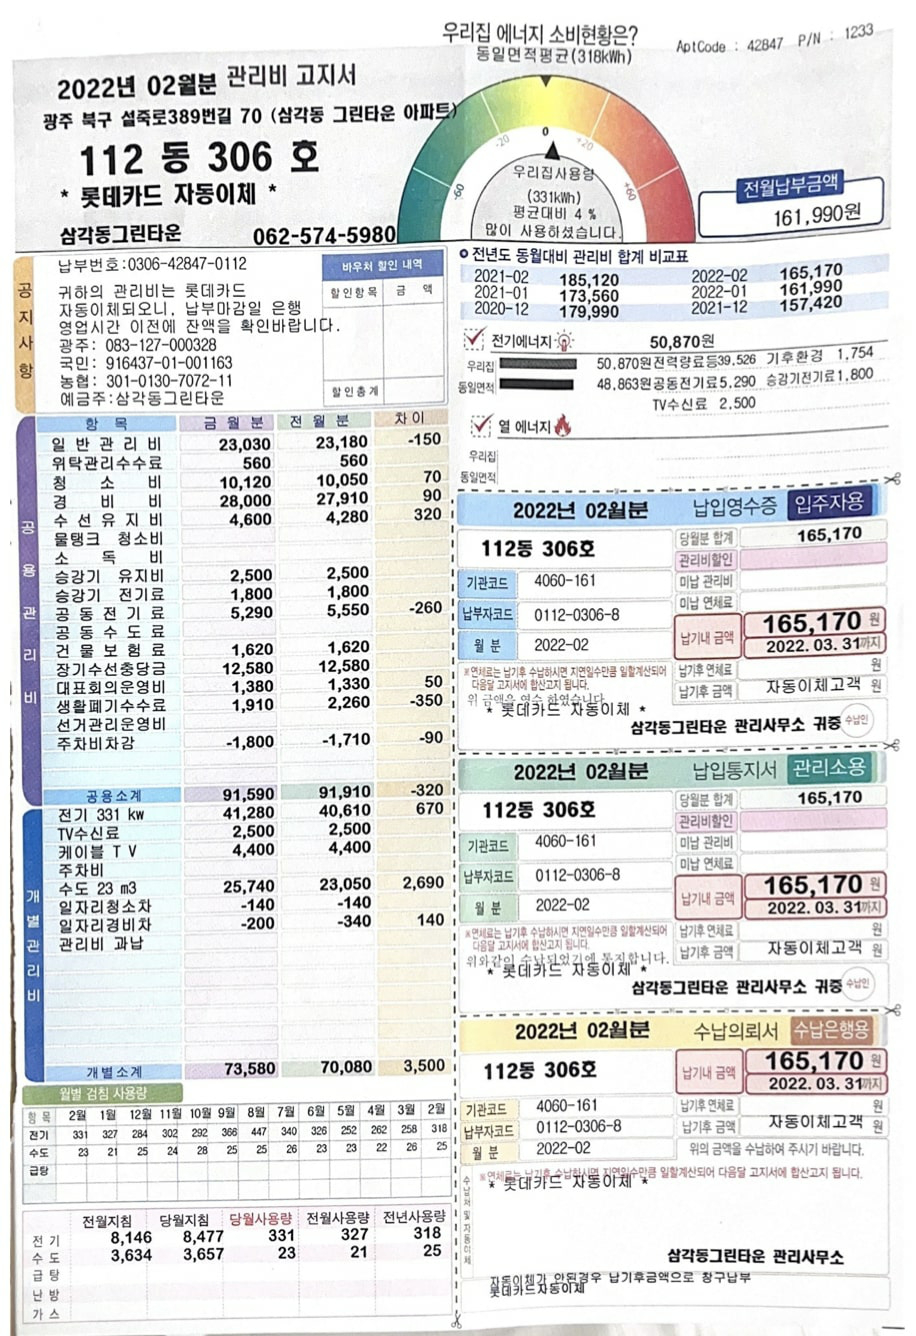

192.168.219.109 - - [01/Jun/2022 17:47:04] "POST /getPhoto HTTP/1.1" 200 -


202202-331-23-41280-25740-91590-165170
POST


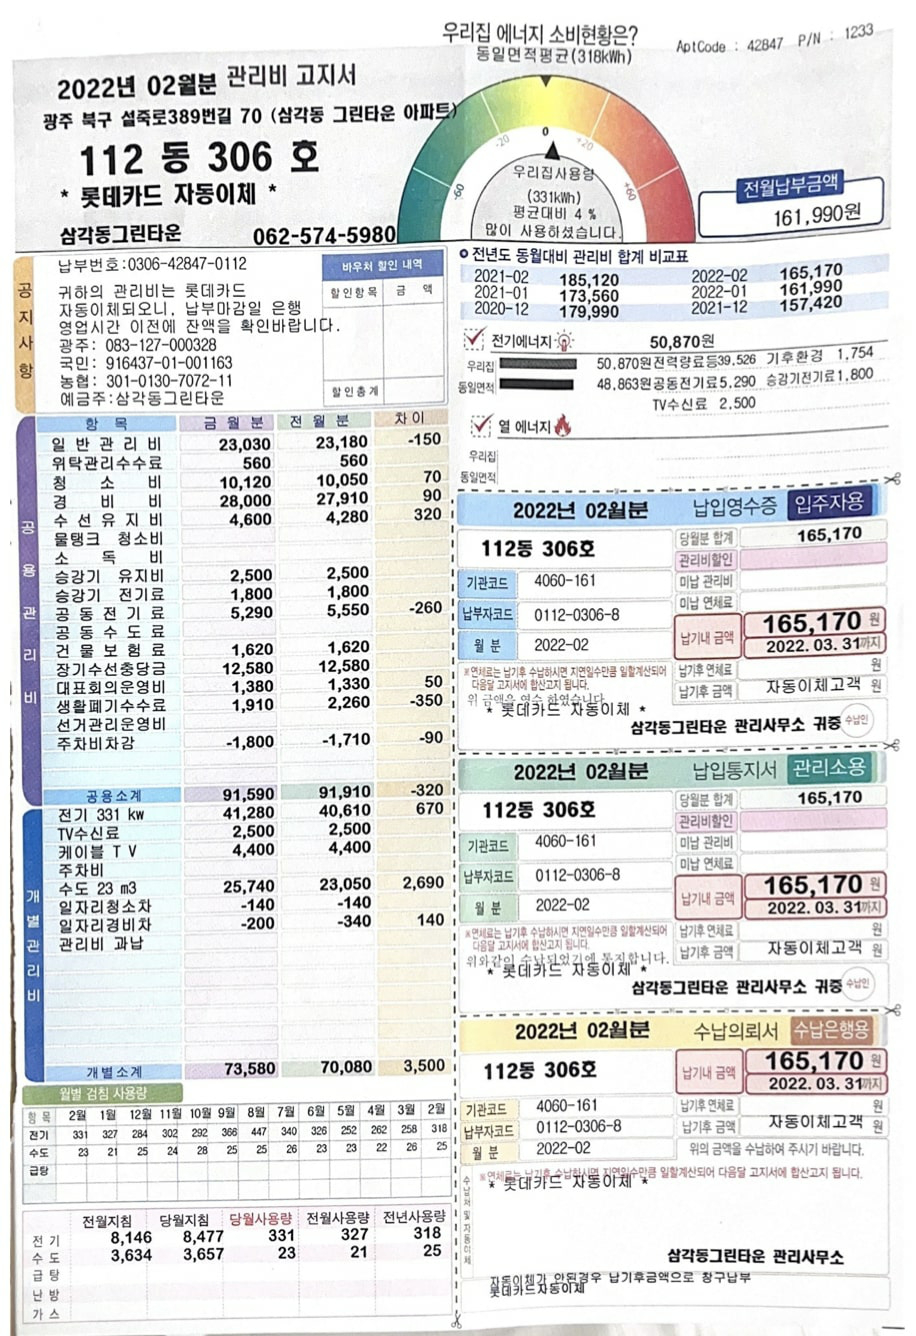

192.168.219.109 - - [01/Jun/2022 17:52:11] "POST /getPhoto HTTP/1.1" 200 -


202202-331-23-41280-25740-91590-165170
==GET Address==
서울특별시 종로구 사직동


192.168.219.102 - - [01/Jun/2022 17:54:39] "GET /getAddress?region1=서울특별시&region2=종로구&region3=사직동 HTTP/1.1" 200 -


60 127
==GET Address==
서울특별시 종로구 사직동


192.168.219.102 - - [01/Jun/2022 17:54:42] "GET /getAddress?region1=서울특별시&region2=종로구&region3=사직동 HTTP/1.1" 200 -


60 127
==GET RealTimeData==
[[[16.8 47.   1.8]
  [16.8 47.   1.8]
  [16.8 47.   1.8]]]
Metal device set to: Apple M1


2022-06-01 17:54:43.726890: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-01 17:54:43.727014: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


==GET RealTimeData==
[[[16.8 47.   1.8]
  [16.8 47.   1.8]
  [16.8 47.   1.8]]]


2022-06-01 17:54:54.392440: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-01 17:54:54.807247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
192.168.219.102 - - [01/Jun/2022 17:54:54] "GET /getRealTimeData?T1H=16.8&REH=47&WSD=1.8 HTTP/1.1" 200 -


0.1066316


2022-06-01 17:54:55.094719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
192.168.219.102 - - [01/Jun/2022 17:54:55] "GET /getRealTimeData?T1H=16.8&REH=47&WSD=1.8 HTTP/1.1" 200 -


0.1066316
==GET Address==
서울특별시 종로구 사직동


192.168.219.102 - - [01/Jun/2022 18:02:55] "GET /getAddress?region1=서울특별시&region2=종로구&region3=사직동 HTTP/1.1" 200 -


60 127
==GET RealTimeData==
[[[16.3 50.   2.7]
  [16.3 50.   2.7]
  [16.3 50.   2.7]]]


2022-06-01 18:03:08.164795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
192.168.219.102 - - [01/Jun/2022 18:03:08] "GET /getRealTimeData?T1H=16.3&REH=50&WSD=2.7 HTTP/1.1" 200 -


0.102676444
==GET Address==
서울특별시 종로구 사직동


192.168.219.102 - - [01/Jun/2022 18:07:11] "GET /getAddress?region1=서울특별시&region2=종로구&region3=사직동 HTTP/1.1" 200 -


60 127
==GET RealTimeData==
[[[16.3 50.   2.7]
  [16.3 50.   2.7]
  [16.3 50.   2.7]]]


2022-06-01 18:07:21.537783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
192.168.219.102 - - [01/Jun/2022 18:07:21] "GET /getRealTimeData?T1H=16.3&REH=50&WSD=2.7 HTTP/1.1" 200 -


0.102676444
==GET Address==
서울특별시 종로구 사직동


192.168.219.102 - - [01/Jun/2022 18:08:52] "GET /getAddress?region1=서울특별시&region2=종로구&region3=사직동 HTTP/1.1" 200 -


60 127
==GET RealTimeData==
[[[16.3 50.   2.7]
  [16.3 50.   2.7]
  [16.3 50.   2.7]]]


2022-06-01 18:09:03.144449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
192.168.219.102 - - [01/Jun/2022 18:09:03] "GET /getRealTimeData?T1H=16.3&REH=50&WSD=2.7 HTTP/1.1" 200 -


0.102676444
==GET Address==
서울특별시 종로구 사직동


192.168.219.102 - - [01/Jun/2022 18:14:38] "GET /getAddress?region1=서울특별시&region2=종로구&region3=사직동 HTTP/1.1" 200 -


60 127
==GET RealTimeData==
[[[16.3 50.   2.7]
  [16.3 50.   2.7]
  [16.3 50.   2.7]]]


2022-06-01 18:14:48.022239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
192.168.219.102 - - [01/Jun/2022 18:14:48] "GET /getRealTimeData?T1H=16.3&REH=50&WSD=2.7 HTTP/1.1" 200 -


0.102676444
==GET Address==
서울특별시 종로구 사직동


192.168.219.102 - - [01/Jun/2022 18:19:31] "GET /getAddress?region1=서울특별시&region2=종로구&region3=사직동 HTTP/1.1" 200 -


60 127
==GET RealTimeData==
[[[16.3 50.   2.7]
  [16.3 50.   2.7]
  [16.3 50.   2.7]]]


2022-06-01 18:19:42.733859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
192.168.219.102 - - [01/Jun/2022 18:19:42] "GET /getRealTimeData?T1H=16.3&REH=50&WSD=2.7 HTTP/1.1" 200 -


0.102676444


In [ ]:
# 모든 host에서 접근 가능
if __name__ == '__main__':
    app.run(host='0.0.0.0',port='5001', threaded=True) #host='0.0.0.0'